In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


# **Predicting Subscriptions**

A research group in Computer Science at UBC wants to predict what kinds of behaviours and player characteristics are more likely to subscribe to a gaming-related newspaper. In this report, we are going to explore if age and hours played affect whether someone will subscribe to the newsletter. We will be analyzing data from the `players.csv` dataframe. This dataframe contains information such as player experience, hours played, gender, age, and more. In this report, we will create a K-nearest neighbours (KNN) classification model to identify patterns and relationships so that we can make accurate predictions.

In [2]:
set.seed(123)
players<-read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


After loading the `players.csv` data, we will now select the columns we need: `Age`, `experience`, `subscribe`. Then we will remove the `NA` values. This will remove rows of the `Age` or `played_hours` columns that do not contain or are missing data. This is important as KNN functions require complete cases. Finally, we need to mutate the `subscribe` column into a factor data type. This is necessary for the classification models we will be doing later on.

In [3]:
set.seed(123)
players<-players|>
select(subscribe, played_hours, Age)|>
filter(!is.na(Age), !is.na(played_hours))|>
mutate(subscribe = as_factor(subscribe))
players

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
⋮,⋮,⋮
TRUE,0.0,20
TRUE,0.0,17
FALSE,0.3,22


We are now going to create a histogram graph. This histogram is going to plot the `Age` of the person and their subscription status (`subscribe`). This graph will coloured by subscription status

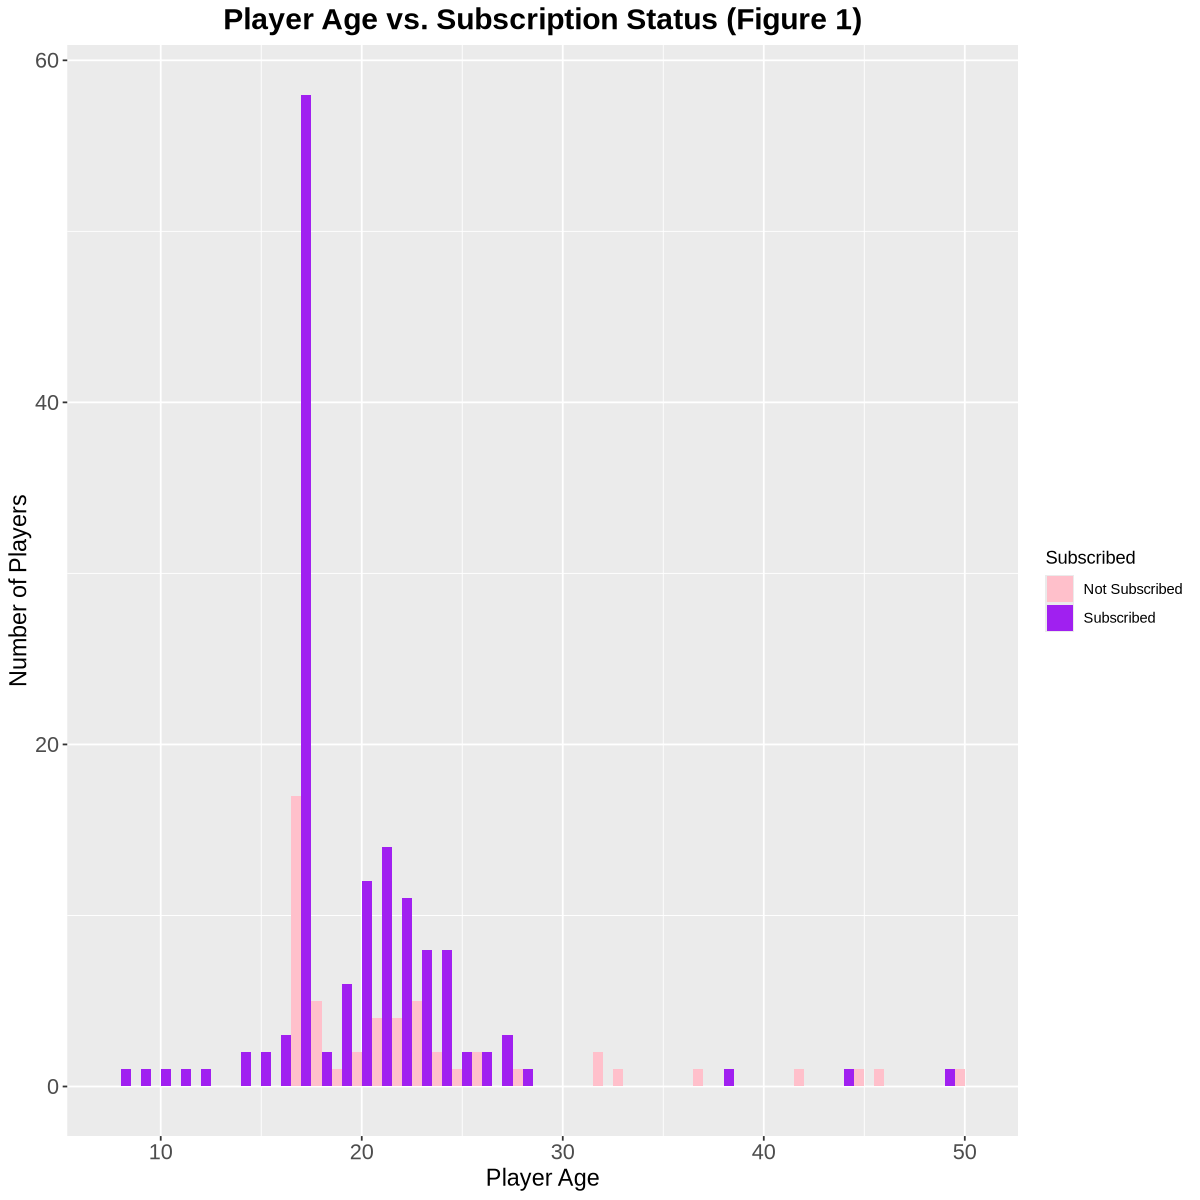

In [9]:
set.seed(123)
 options(repr.plot.width = 10, repr.plot.height = 10) 
player_age_plot<- players|> 
ggplot(aes(x = Age, fill = subscribe)) +
geom_histogram(position = "dodge", binwidth=1) + 
labs(x = "Player Age", y = "Number of Players", fill = "Subscribed",
title = "Player Age vs. Subscription Status (Figure 1)") +
scale_fill_manual(values = c("FALSE" = "pink", "TRUE" = "purple"),labels = c("Not Subscribed", "Subscribed")) +
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
player_age_plot

Figure 1 shows the distribution of player ages, separated by subscription status. The purple bars represent the subscribed population while the pink bars represent the not subscribed population. Based on the graph you can see that the majority of people who subscribe to gaming related newspappers are younger. The majority of subscribers are under the age of 30 years old. 

Next we will create another histogram but this time we will be plotting `played_hours` and subscription status (`subscribe`). This graph will also have subscription status seperated by colour

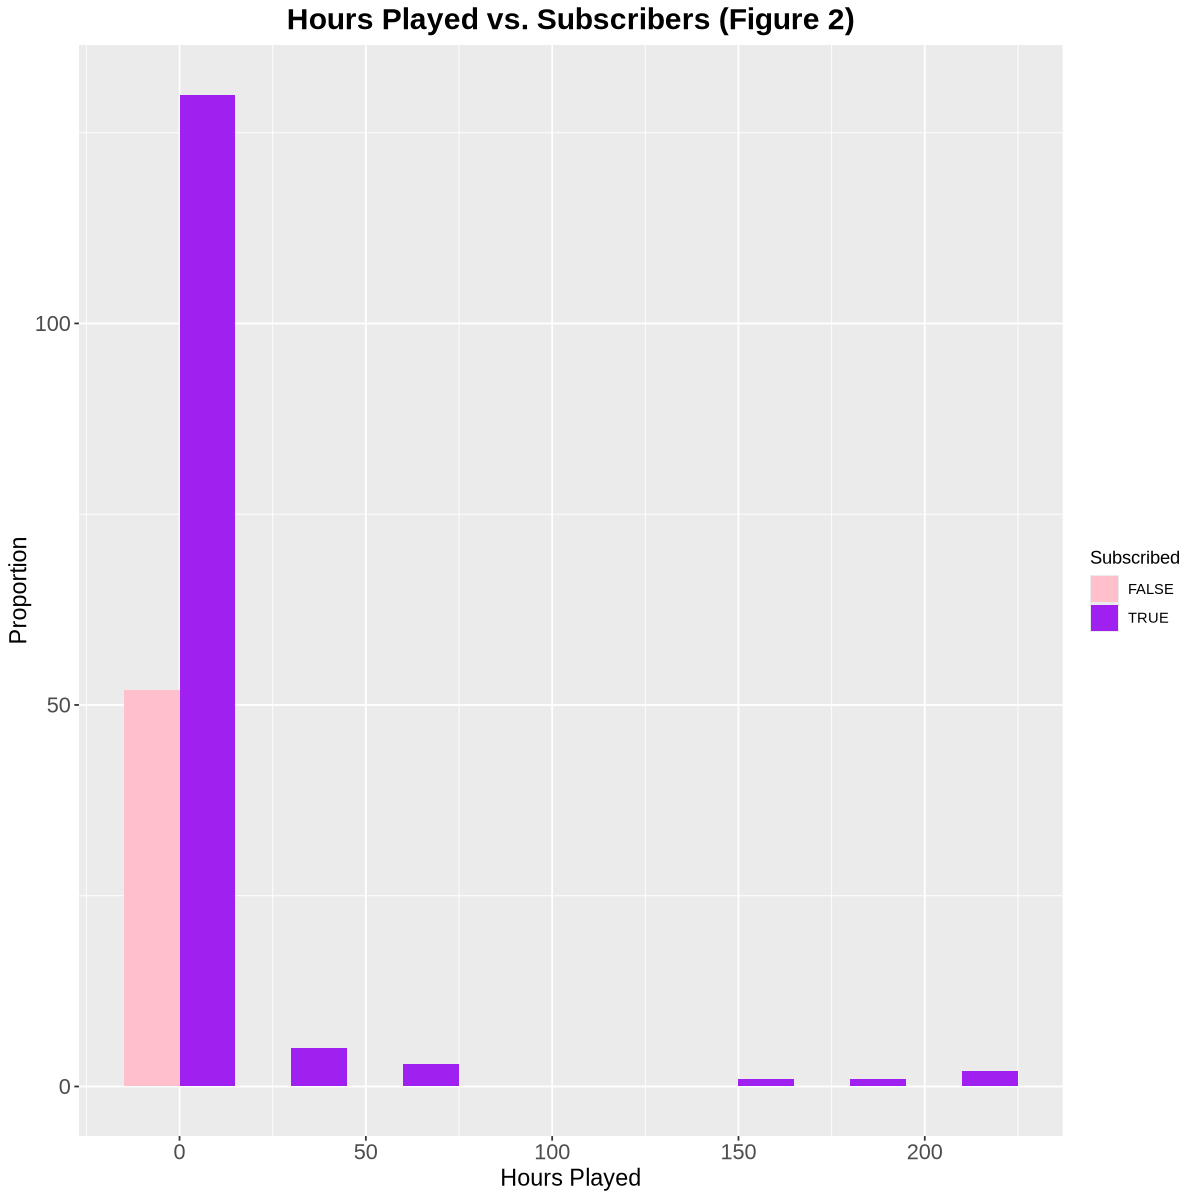

In [14]:
set.seed(123)
options(repr.plot.width = 10, repr.plot.height = 10) 
hours_played_plot<-players|>
ggplot(aes(x=played_hours, fill=subscribe))+
geom_histogram(position="dodge", binwidth=30)+
labs(x="Hours Played", y="Proportion", fill="Subscribed")+
scale_fill_manual(values = c("TRUE" = "purple", "FALSE" = "pink")) +
ggtitle("Hours Played vs. Subscribers (Figure 2)")+
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
hours_played_plot

Figure 2 shows the distribution of hours played, seperated by subscription status, The purple bars represent the subscribed population while the pink bars represent the not subscribed population. Based on the graph, all of those who don't subscribe to the newspaper played the least amount of hours. This graph also shows that people who play more hours of minecraft are more likely to be subscribed. 

Now that we know that there is a correlation between age and subscription and hours played and subscription, we are going to create a knn-classfication model. To do this we are going to start with splitting the data. We are going to split the data into 75% `training_data` and 25% `testing_data`

In [17]:
set.seed(123)
data_split<-initial_split(players, prop = 0.8, strata = subscribe)
data_split
training_data<-training(data_split)
training_data
testing_data<-testing(data_split)
testing_data

<Training/Testing/Total>
<154/40/194>

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,22
FALSE,0.1,17
FALSE,0.0,23
FALSE,0.0,33
FALSE,1.4,25
⋮,⋮,⋮
TRUE,0.8,22
TRUE,32.0,22
TRUE,0.1,44


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,3.8,17
FALSE,0.0,17
FALSE,0.0,21
TRUE,48.4,17
TRUE,0.3,8
⋮,⋮,⋮
TRUE,0.4,17
FALSE,0.2,17
TRUE,0.0,17


write about creating a recipe

In [18]:
set.seed(123)
subscribe_recipe<-recipe(subscribe~Age+played_hours, data=training_data)|>
step_scale(all_predictors())|>
step_center(all_predictors())
subscribe_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



write about creating spec

In [19]:
set.seed(123)
subscribe_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
set_engine("kknn")|>
set_mode("classification")
subscribe_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


write about creating fit workflow

In [20]:
set.seed(123)
subscribe_fit<-workflow()|>
add_recipe(subscribe_recipe)|>
add_model(subscribe_spec)|>
fit(data=training_data)
subscribe_fit

Warning message:
“tune samples were requested but there were 154 rows in the data. 149 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2662338
Best kernel: rectangular
Best k: 149

create about vfold

In [21]:
set.seed(123)
subscribe_vfold<-vfold_cv(training_data, v = 5, strata = subscribe)
subscribe_vfold

Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 122, 123, 124

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NUL

write about resampling

In [22]:
set.seed(123)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

subscribe_resample_fit<-workflow()|>
add_recipe(subscribe_recipe)|>
add_model(subscribe_spec)|>
tune_grid(resamples=subscribe_vfold, grid=k_vals)|>
collect_metrics()
subscribe_resample_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4800134,5,0.02853938,Preprocessor1_Model01
1,roc_auc,binary,0.5247365,5,0.02790451,Preprocessor1_Model01
2,accuracy,binary,0.4866801,5,0.02853859,Preprocessor1_Model02
2,roc_auc,binary,0.5518198,5,0.03405302,Preprocessor1_Model02
3,accuracy,binary,0.5449731,5,0.01988937,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,roc_auc,binary,0.5817056,5,0.05773320,Preprocessor1_Model08
9,accuracy,binary,0.6365726,5,0.04651066,Preprocessor1_Model09
9,roc_auc,binary,0.5423968,5,0.05159371,Preprocessor1_Model09


write about accuracy

In [23]:
set.seed(123)
accuracy <- subscribe_resample_fit |> 
       filter(.metric=="accuracy")
accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4800134,5,0.02853938,Preprocessor1_Model01
2,accuracy,binary,0.4866801,5,0.02853859,Preprocessor1_Model02
3,accuracy,binary,0.5449731,5,0.01988937,Preprocessor1_Model03
4,accuracy,binary,0.5256183,5,0.02300091,Preprocessor1_Model04
5,accuracy,binary,0.5780780,5,0.03435795,Preprocessor1_Model05
6,accuracy,binary,0.5711962,5,0.04408481,Preprocessor1_Model06
7,accuracy,binary,0.5845296,5,0.02461755,Preprocessor1_Model07
8,accuracy,binary,0.5845296,5,0.02461755,Preprocessor1_Model08
9,accuracy,binary,0.6365726,5,0.04651066,Preprocessor1_Model09


write about creating graph

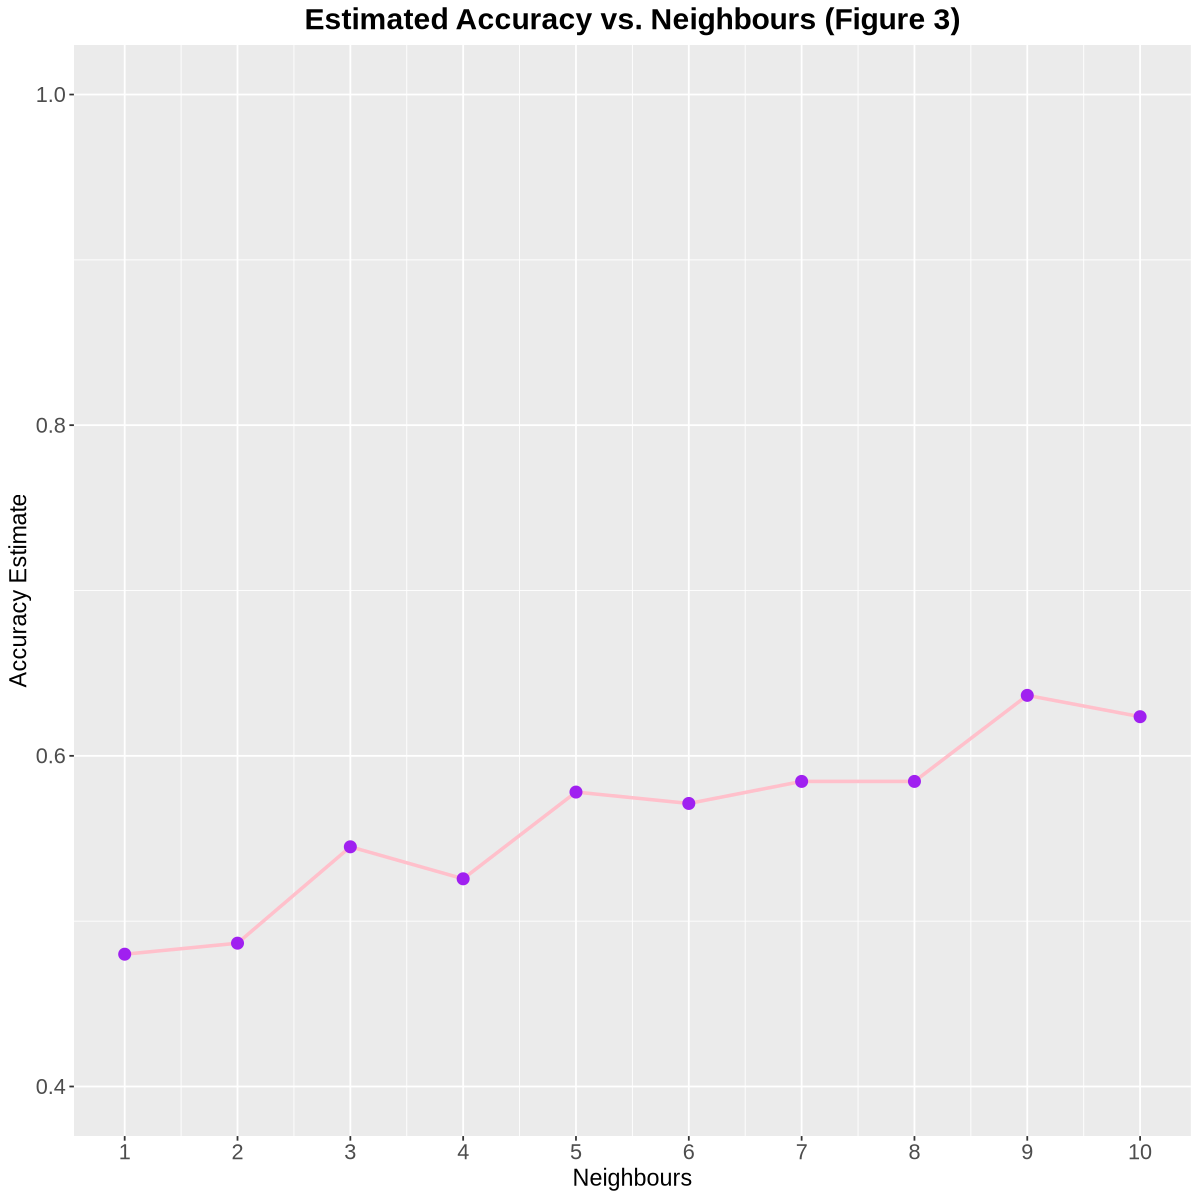

In [24]:
set.seed(123)
accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
geom_line(color = "pink", linewidth = 1) +
geom_point(size = 3, color = "purple") +
labs(x = "Neighbours", y = "Accuracy Estimate") +
scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
scale_y_continuous(limits = c(0.4, 1.0)) +
ggtitle("Estimated Accuracy vs. Neighbours (Figure 3)")+
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
accuracy_versus_k

write about results of fig 3

write about finding best k

In [25]:
set.seed(123)
best_k <- accuracy |>
  slice_max(mean, n = 1)
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.6365726,5,0.04651066,Preprocessor1_Model09


write all in one about creating best k spec, and workflow

In [26]:
set.seed(123)
best_k_spec<-nearest_neighbor(weight_func="rectangular", neighbors=9)|>
set_engine("kknn")|>
set_mode("classification")
best_k_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 9
  weight_func = rectangular

Computational engine: kknn 


In [27]:
set.seed(123)
best_k_fit<-workflow()|>
add_recipe(subscribe_recipe)|>
add_model(best_k_spec)|>
fit(data=training_data)
best_k_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4025974
Best kernel: rectangular
Best k: 9

write about prediction 

In [28]:
set.seed(123)
player_predictions=predict(best_k_fit, testing_data)|>
bind_cols(testing_data)
player_predictions

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,3.8,17
FALSE,FALSE,0.0,17
TRUE,FALSE,0.0,21
TRUE,TRUE,48.4,17
TRUE,TRUE,0.3,8
⋮,⋮,⋮,⋮
TRUE,TRUE,0.4,17
TRUE,FALSE,0.2,17
FALSE,TRUE,0.0,17


write about player metrics 

In [29]:
set.seed(123)
player_metrics <-player_predictions|>
metrics(truth = subscribe, estimate = .pred_class)
player_metrics
metrics_formatted <-player_metrics|>
mutate(.estimate = percent(.estimate, accuracy = 0.1))
metrics_formatted

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7250000
kap,binary,0.2903226


.metric,.estimator,.estimate
<chr>,<chr>,<chr>
accuracy,binary,72.5%
kap,binary,29.0%


write about conf_mat

In [30]:
set.seed(123)
player_mat<-player_predictions|>
conf_mat(truth=subscribe, estimate = .pred_class)
player_mat

          Truth
Prediction FALSE TRUE
     FALSE     5    5
     TRUE      6   24